# Exercise 02: Random Graphs and Small-World Networks


In this week's assignment, we explore some of the models for random graphs and small-world networks that we have introduced. We specifically study how diameter, clustering coefficient, and degree distribution of random graphs are related to the parameters of the $G(n,p)$ model. We further implement the Watts-Strogatz model and explore how its parameters influence those characteristics that are associated with the small-world property of complex networks.

In [1]:
#BOILERPLATECODE

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

import time
from tqdm import tqdm

## Task 1: Erdös-Rényi networks

### 1.1 The G(n,p) model

Implement a python function that generates a random graph according to the G(n,p) model for undirected networks. Test your function by generating (and visualising) three microstates generated for $n=50$ and $p \in \{1\%,5\%,10\%\}$.

In [2]:
#BOILERPLATECODE

def Gnp(n, p):
    g = nx.Graph()
    for i in range(n):
        g.add_node(i)
    
    adj = np.zeros([n,n])
    adj[np.triu_indices_from(adj, k=1)] = np.random.rand(int(n*(n-1)/2))<p
        
    row, col = adj.nonzero()
    
    for r,c in zip(row, col):
        g.add_edge(r,c)
    
    return g

For p = 0.01, fraction of nodes in the largest connected component = 0.10


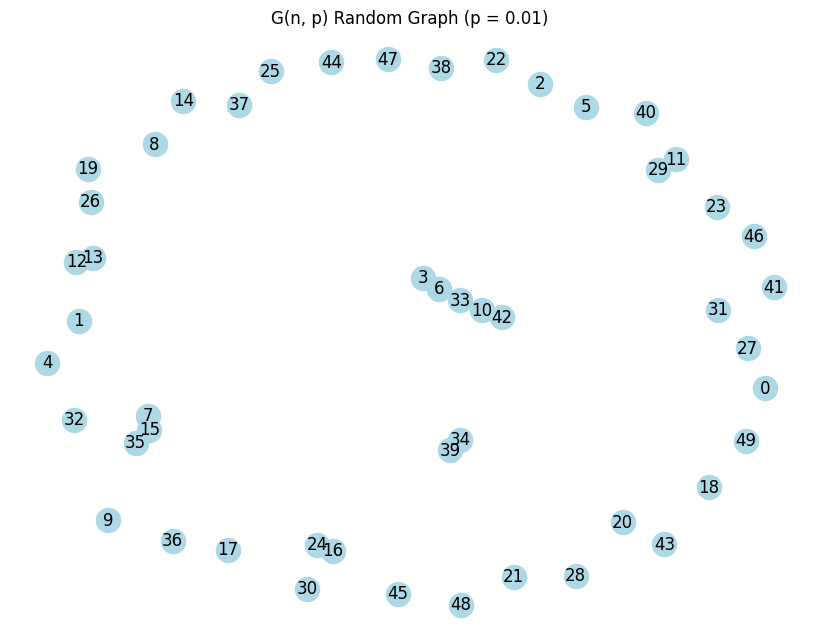

For p = 0.05, fraction of nodes in the largest connected component = 0.90


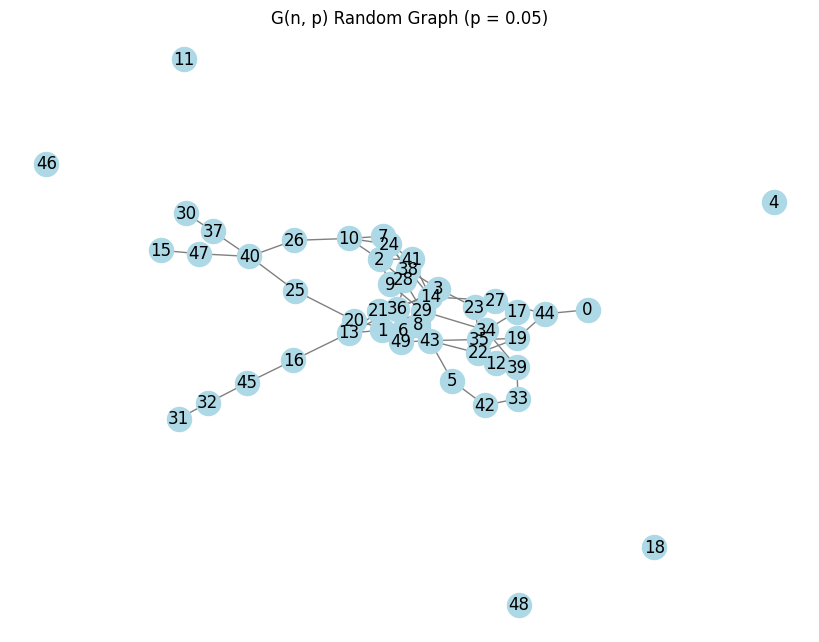

For p = 0.10, fraction of nodes in the largest connected component = 1.00


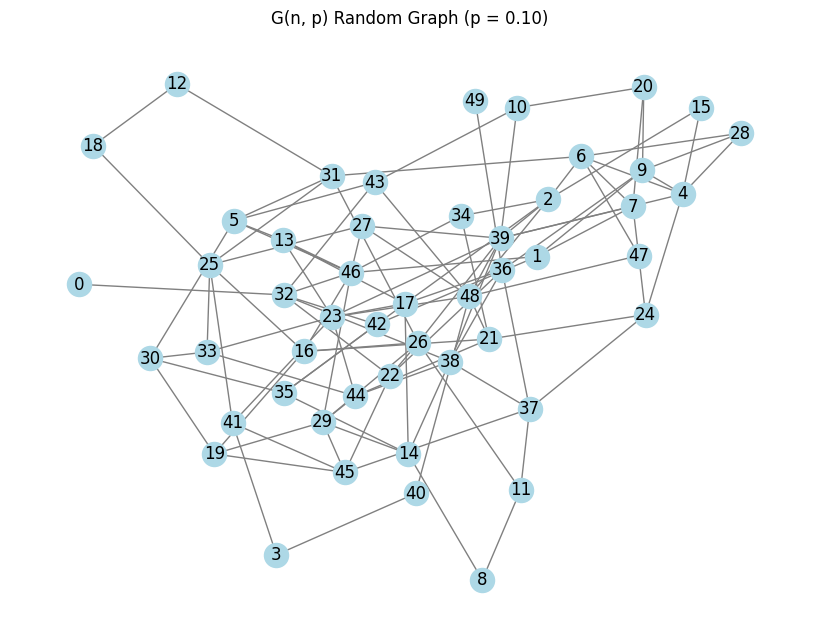

In [3]:
n = 50
for p in [0.01, 0.05, 0.1]:
    g = Gnp(n, p)
    
    n_tot = g.number_of_nodes()
    if n_tot == 0:
        lcc_size = 0
    else:
        if nx.is_connected(g):
            lcc_size = 1.0
        else:
            largest_cc = max(nx.connected_components(g), key=len)
            lcc_size = len(largest_cc) / n_tot
    print("For p = {:.2f}, fraction of nodes in the largest connected component = {:.2f}".format(p, lcc_size))

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title("G(n, p) Random Graph (p = {:.2f})".format(p))
    plt.show()
    



Simulating p values: 100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


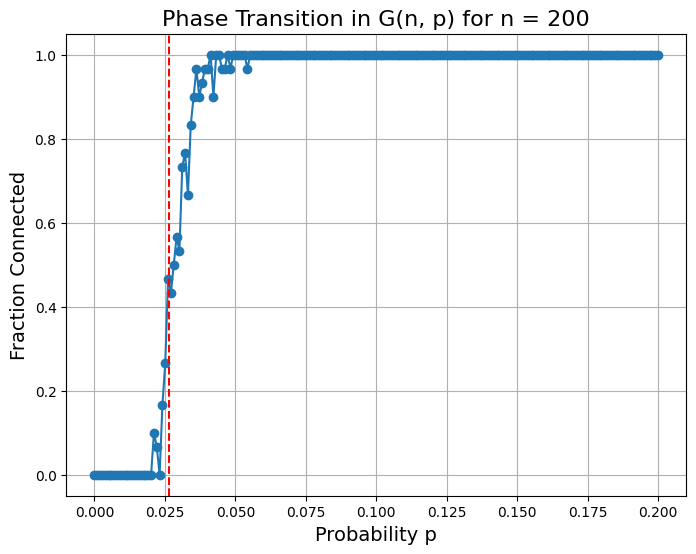

0.02649158683274018


In [13]:
def phase_transition(n=100, p_values=np.linspace(0, 1, 20), iterations=20):

    fraction_connected = []
    
    for p in tqdm(p_values, desc="Simulating p values"):
        connected_count = 0
        for _ in range(iterations):
            g = Gnp(n, p)
            # Check if the graph is connected
            if nx.is_connected(g):
                connected_count += 1
        fraction_connected.append(connected_count / iterations)
    
    plt.figure(figsize=(8, 6))
    plt.plot(p_values, fraction_connected, marker='o', linestyle='-')
    # plot the line of the phase transition at p_c = log(n) / n
    plt.axvline(x=np.log(n) / n, color='r', linestyle='--', label='p = log(n) / n')
    plt.xlabel('Probability p', fontsize=14)
    plt.ylabel('Fraction Connected', fontsize=14)
    plt.title(f'Phase Transition in G(n, p) for n = {n}', fontsize=16)
    plt.grid(True)
    plt.show()

# Example usage:
n = 200
p_values = np.linspace(0, .2, 200)
phase_transition(n=n, p_values=p_values, iterations=30)

print(np.log(n)/n)

### 1.2 Diameter in Random Graphs

For $20$ uniformly spaced points $n$ in the interval $[100,2000]$ and a fixed mean degree $np=4$, compute the diameter $diam(n)$ of the largest connected components of microstates generated by the $G(n,p)$ model. Plot the empirical diameter $diam(n)$  (y-axis) against the number of nodes $n$ (x-axis). What do you observe?

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


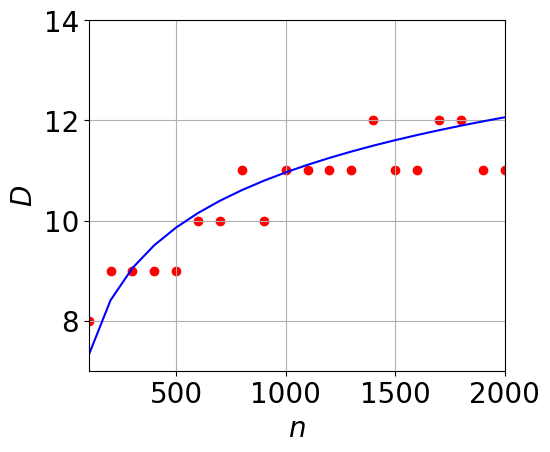

In [14]:
def average_diameter(mean_degree, n, samples=1):
    diam = 0
    for i in range(samples):
        g = Gnp(n, mean_degree/n)

        if nx.is_connected(g):
            g_lcc = g
        else:
            largest_cc = max(nx.connected_components(g), key=len)
            g_lcc = g.subgraph(largest_cc).copy()
        
        diam += nx.diameter(g_lcc)
    return diam / samples

def plot_diameter(mean_degree, n_range, samples=1):
    diams = []
    for n in tqdm(n_range):
        diams.append(average_diameter(mean_degree, int(n), samples))
        
    plt.clf()    
    x = plt.scatter(n_range, diams, color='red')
    predicted = [2.2*np.log(n)/np.log(mean_degree) for n in n_range]
    x = plt.plot(n_range, predicted, color='blue')
    plt.axis([min(n_range), max(n_range), 7, max(diams)+2])
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)  
    plt.xlabel('$n$', fontsize=20)
    plt.ylabel('$D$', fontsize=20)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(left=0.25)
    plt.show()


# Define a range of n values (number of nodes)
n_range = np.linspace(100, 2000, 20)
plot_diameter(4, n_range, samples=1)

### 1.3 Clustering coefficient in the G(n,p) model

For $50$ uniformly spaced points $p$ in the interval $[0,0.15]$, create microstates of the $G(n,p)$ model with $n=200$ and compute the global clustering coefficient $C$ of the microstates. For each point $p$ generate $5$ microstates and average the global clustering coefficients of these individual microstates. Plot the average values of $C$ (y-axis) against $p$ (x-axis) and interpret your results.

In [15]:
# clustering coefficient as defined in the previous exercise
def local_clustering_coefficient(G, node):

    neighbors = list(G.neighbors(node))
    d = len(neighbors)
    if d < 2:
        return 0.0 
    
    # Count the number of edges between the neighbors.
    links = 0
    for i in range(d):
        for j in range(i+1, d):
            if G.has_edge(neighbors[i], neighbors[j]):
                links += 1
                
    return (2 * links) / (d * (d - 1))


def global_clustering_coefficient(G):

    coeffs = [local_clustering_coefficient(G, node) for node in G.nodes()]
    return np.mean(coeffs)

100%|██████████| 50/50 [00:01<00:00, 28.39it/s] 


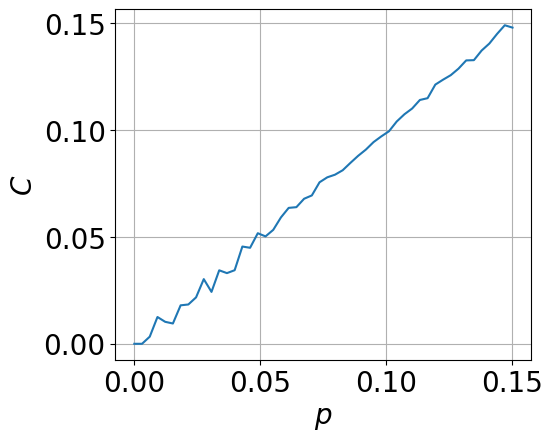

In [16]:

def average_clustering_coeff(n, p, samples=1):
    cc = 0
    for i in range(samples):
        g = Gnp(n, p)
        cc += global_clustering_coefficient(g)
    return cc/samples


def plot_clustering_coeff(n, p_range, samples=1):
    ccs = []
    
    for p in tqdm(p_range):
        ccs.append(average_clustering_coeff(n, p, samples))
        
    plt.clf()
    x = plt.plot(p_range, ccs)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)     
    plt.grid(True)
    plt.xlabel('$p$', fontsize=20)
    plt.ylabel('$C$', fontsize=20)     
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(left=0.25)    
    plt.show()

p_range = np.linspace(0, 0.15, 50)
plot_clustering_coeff(200, p_range, samples=5)

Repeat the experiment from above for a fixed value of $np=4$ and $20$ uniformly spaced points $n$ in the interval $[100,2000]$. For this, you should adapt the functions from above accordingly. Again, plot the average values of $C$ (y-axis) against $n$ (x-axis) and interpret your results.

100%|██████████| 20/20 [00:02<00:00,  7.43it/s]


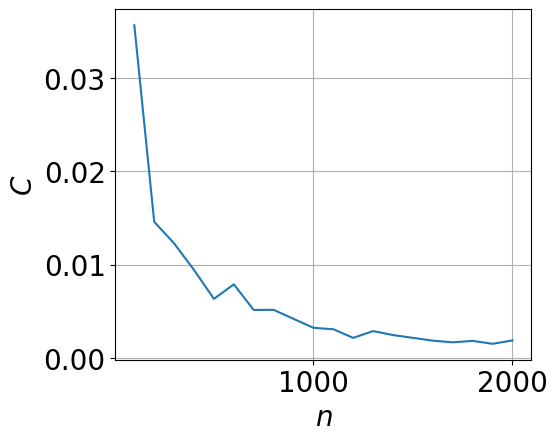

In [17]:
def plot_clustering_coeff(n_range, mean_degree, samples=1):
    ccs = []
    
    for n in tqdm(n_range):
        ccs.append(average_clustering_coeff(int(n), mean_degree/n, samples))
        
    plt.clf()
    x = plt.plot(n_range, ccs)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.grid(True)
    plt.xlabel('$n$', fontsize=20)
    plt.ylabel('$C$', fontsize=20)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(left=0.25)
    plt.show()

n_range = np.linspace(100, 2000, 20)
plot_clustering_coeff(n_range, mean_degree=4, samples=5)

- **Global Clustering as Conditional Probability:**  
  The global clustering coefficient can be seen as the probability of a link $(j,k)$ existing, given that links $(i,j)$ and $(i,k)$ exist. For independent events, since 
  $$
  P(A|B) = P(A),
  $$
  in the $G(n,p)$ model the probability for link $(i,k)$ is simply $p$.

  For large $n$, the fraction of closed triads in $G(n,p)$ converges to $p$.

- **Relating $p$ to Empirical Networks:**  
  For a network with $n$ nodes and $m$ links, the average degree is
  $$
  \langle k \rangle = \frac{2m}{n}.
  $$
  In the $G(n,p)$ model, $\langle k \rangle = np$, hence
  $$
  p = \frac{\langle k \rangle}{n} = \frac{2m}{n^2}.
  $$

- **Clustering Coefficient Expectations:**  
  - **Dense Networks:** With $p$ fixed, $C \propto p$.  
  - **Sparse Networks:** With $\langle k \rangle = np = \text{constant}$, $C \to 0$ as $n \to \infty$.

Do your results match this expectation?

## Task 2: Small-world networks

### 2.1 The Watts-Strogatz model

Implement the Watts-Strogatz model with $s=5$ for the initial case of a ring-lattice as presented in lecture L03. Generate and plot random realisations with $n=25$ nodes and rewiring probabilities of $p=0$, $p=0.04$ and $p=1$.

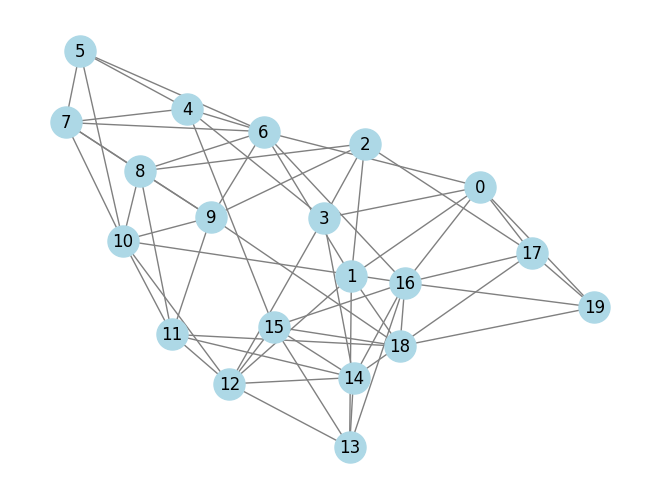

In [18]:
def WattsStrogatz(n, s, p):
    g = nx.Graph()
    for i in range(n):
        g.add_node(str(i))
    
    # construct a ring lattice (dimension 1)
    for i in range(n):
        for j in range(1, s + 1):
            g.add_edge(str(i), str((i + j) % n))
    
    edgelist = list(g.edges())
    for (v, w) in edgelist:
        if np.random.rand() < p:
            # Delete original link and remember source node
            if g.has_edge(v, w):
                g.remove_edge(v, w)
            
            # Select new target.
            # Targets can be any node that v is currently not connected to.
            possible_targets = [x for x in g.nodes() if x != v and not g.has_edge(v, x)]
            if possible_targets: 
                new_w = np.random.choice(possible_targets)
                g.add_edge(v, new_w)
                
    return g

g_ws = WattsStrogatz(20, 3, 0.2)
nx.draw_spring(g_ws, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

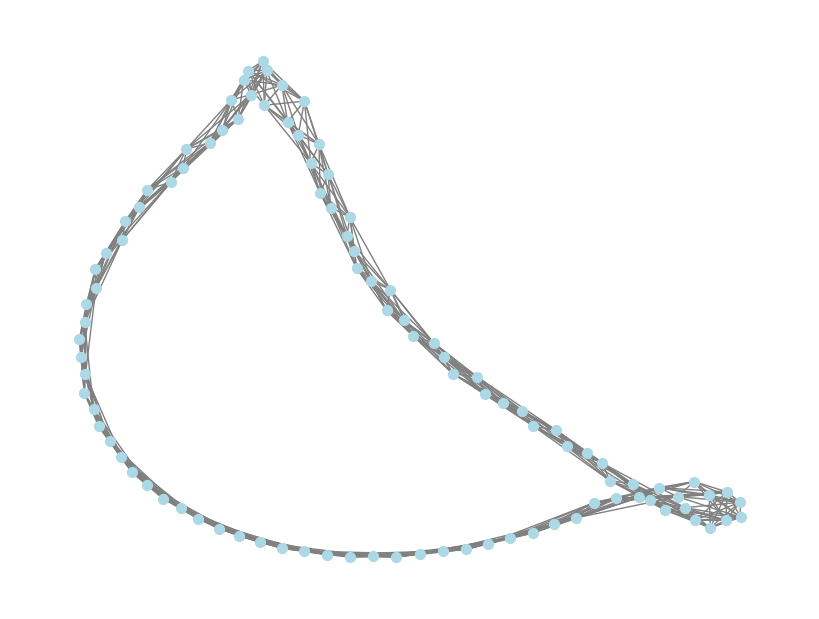

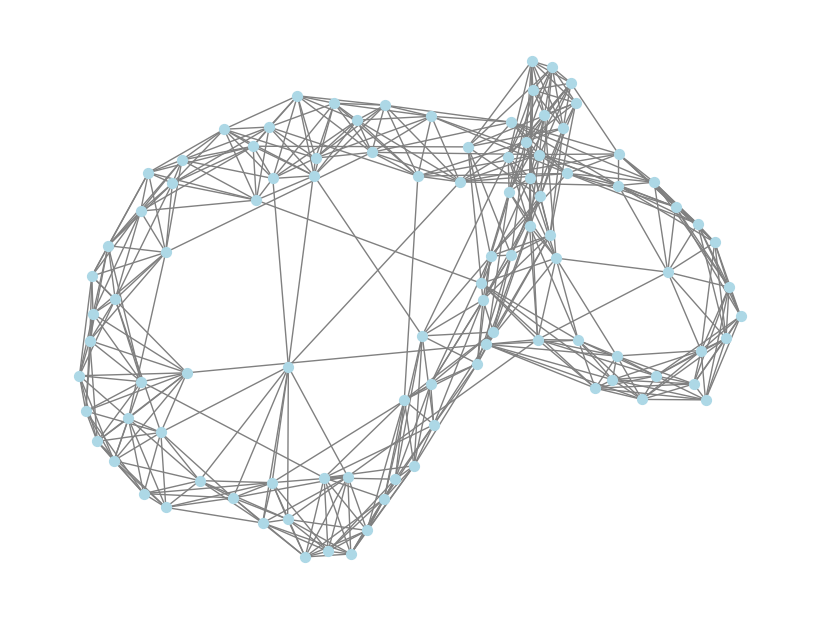

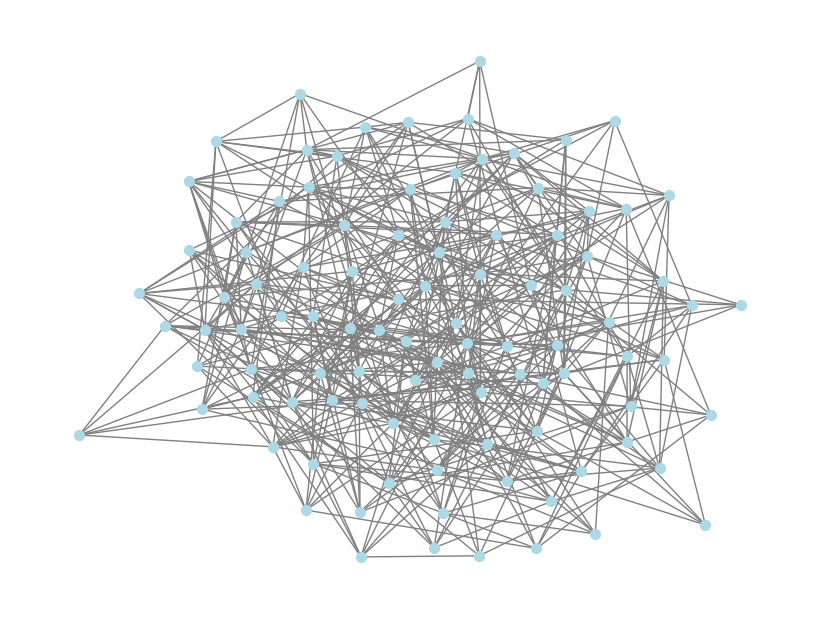

In [19]:
n = 100
s = 5
for p in [0,.04,1]:
    plt.figure(figsize = (8,6))
    nx.draw_spring(WattsStrogatz(n, s, p), with_labels=False, node_color='lightblue', edge_color='gray', node_size=50)
    plt.show()

### 2.2 The small-world regime of the Watts-Strogatz model

In the following, we will recreate the results of the slide "Watts-Strogatz: the small-world regime" from lecture 3. We use your implementation to generate a number of realisations for a fixed value of $n=1000$ and 20 logarithmically-spaced values of the rewiring parameter $p$ between $10^{-4}$ and $1$. For each value of $p$, we generate 20 samples and calculate the relative average global clustering coefficient and average shortest path length across these samples (relative to the ring lattice, `cc_norm = (3*s - 3) / (4*s - 2)`). For the average shortest path length, consider only the largest connected component and use the function `nx.average_shortest_path_length`.

100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


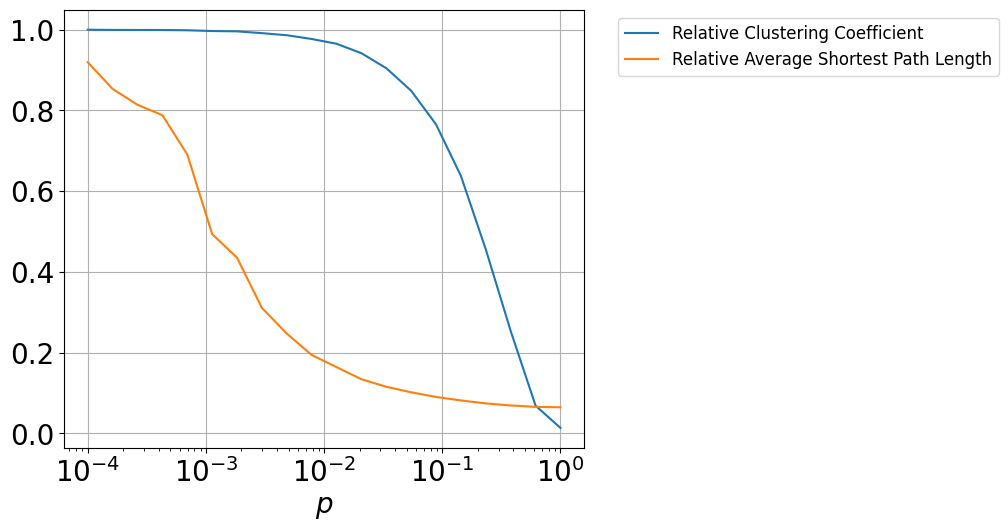

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_small_world(n, s, p_range, samples=1):
    ccs = []  
    apls = []

    ws_ring = WattsStrogatz(n, s, p=0)
    # Theoretical normalization for clustering coefficient for a ring lattice is:
    cc_norm = (3*s - 3) / (4*s - 2)
    # Compute average shortest path length for the ring lattice.
    if nx.is_connected(ws_ring):
        apl_norm = nx.average_shortest_path_length(ws_ring)
    else:
        largest_cc = max(nx.connected_components(ws_ring), key=len)
        ws_ring_lcc = ws_ring.subgraph(largest_cc).copy()
        apl_norm = nx.average_shortest_path_length(ws_ring_lcc)
    
    for p in tqdm(p_range):
        cc_total = 0
        apl_total = 0
        for i in range(samples):
            ws = WattsStrogatz(n, s, p)
            cc_total += nx.average_clustering(ws)
            
            # For average path length, we work with the largest connected component.
            if nx.is_connected(ws):
                apl_total += nx.average_shortest_path_length(ws)
            else:
                largest_cc = max(nx.connected_components(ws), key=len)
                ws_lcc = ws.subgraph(largest_cc).copy()
                apl_total += nx.average_shortest_path_length(ws_lcc)
                
        # Normalize the measured values by those of the ring lattice.
        ccs.append(cc_total/samples / cc_norm)
        apls.append(apl_total/samples / apl_norm)
        
    plt.figure(figsize=(8, 6))
    plt.plot(p_range, ccs, label='Relative Clustering Coefficient')
    plt.plot(p_range, apls, label='Relative Average Shortest Path Length')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)     
    plt.grid(True)
    plt.xscale('log')
    plt.xlabel('$p$', fontsize=20)
    plt.subplots_adjust(bottom=0.15, left=0.25)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.show()

# Define the range of p values (log-spaced)
p_range = np.logspace(-4, 0, 20)
plot_small_world(1000, 5, p_range, samples=10)
